## MTH9893 Time Series Analysis HW1
* Group 01
* Author: Pan, Hongchao & Sun, Yu
* Kernel version: Python 3.5
* Packages: pandas_datareader, datetime, pandas, statsmodels
* Data: 02/04/2007-02/05/2017 **Adjust close price** of 'SPY' and 'IWV'
* Notes: **Please install pandas before running the notebook**
* Notes: **The total running time of this notebook may up to 5min and please do not comment the tables and figures**

### Question 1

In [1]:
# import the packages
# using DataReader function from pandas_datareader
# Ref: https://github.com/pydata/pandas-datareader/blob/master/pandas_datareader/data.py
from pandas_datareader import data
import datetime as dt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Define a function to get the data
def get_data():
    # Reading the historical daily returns of SPY and IWV over the last 10 years
    start, end=dt.datetime(2007,2,4),dt.datetime(2017,2,5)
    data1=data.DataReader('SPY',data_source='yahoo',start=start,end=end)
    data2=data.DataReader('IWV',data_source='yahoo',start=start,end=end)
    
    # Rename the Adj close of two tickers
    data1.rename(columns={'Adj Close':'SPY Adj Close'},inplace=True)
    data2.rename(columns={'Adj Close':'IWV Adj Close'},inplace=True)
    
    # Merge the data and only use the adjust close price for both tickers
    dataAll=data1.merge(data2,left_index=True,right_index=True).loc[:,['SPY Adj Close','IWV Adj Close']]
    dataAll['SPY Adj Close']=dataAll['SPY Adj Close'].astype(float)
    dataAll['IWV Adj Close']=dataAll['IWV Adj Close'].astype(float)
    
    # Get the log/percentage returns
    dataAll['SPY log return']=np.log(dataAll['SPY Adj Close']).diff()[1:]
    dataAll['IWV log return']=np.log(dataAll['IWV Adj Close']).diff()[1:]
    dataAll['SPY pert return']=dataAll['SPY Adj Close'].pct_change()
    dataAll['IWV pert return']=dataAll['IWV Adj Close'].pct_change()
    
    # Get the difference of returns between two tickers
    dataAll['log difference']=dataAll['SPY log return']-dataAll['IWV log return']
    dataAll['pert difference']=dataAll['SPY pert return']-dataAll['IWV pert return']
    
    return dataAll


In [3]:
dataAll=get_data()

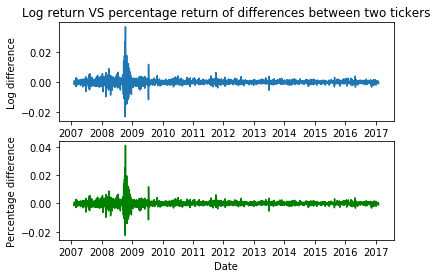

In [4]:
# Plot the log differences VS percentage differences
plt.figure(1)
plt.subplot(211)
plt.title('Log return VS percentage return of differences between two tickers')
plt.plot(dataAll['log difference'])
plt.ylabel('Log difference')
plt.xlabel('Date')

plt.subplot(212)
# Plot the percentage differences
plt.plot(dataAll['pert difference'],color='green')
plt.ylabel('Percentage difference')
plt.xlabel('Date')
plt.show()


Figure 1 Log return and percentage return comparison of differences between two tickers over past 10 years

In [5]:
# Set the maximum lags of AR model to a variable
# max_ma=0: us AR model
# ic: use AIC and BIC criteria
def LagAnalysis(maxAR):
    ST=time.time()
    LogRes=sm.tsa.arma_order_select_ic(dataAll['log difference'].dropna(),max_ar=maxAR,max_ma=0,ic=['aic','bic'],trend='c')
    PertRes=sm.tsa.arma_order_select_ic(dataAll['pert difference'].dropna(),max_ar=maxAR,max_ma=0,ic=['aic','bic'],trend='c')
    ET=time.time()
    
    return (LogRes, PertRes, ET-ST)


In [6]:
# Compare the performance of different maxlag of AR model
def performance(maxARs):
    cols=['maxlag','p of log based on aic','p of log based on bic','p of pert based on aic','p of pert based on bic','running time(s)']
    ind=[i for i in range(len(maxARs))] 
    
    # Use list comprehension to avoid for loop
    res=[[ar, LagAnalysis(ar)[0].aic_min_order[0], LagAnalysis(ar)[0].bic_min_order[0],
                   LagAnalysis(ar)[1].aic_min_order[0],LagAnalysis(ar)[1].bic_min_order[0],LagAnalysis(ar)[2]] for ar in maxARs]

    # Get the corresponding value
    df=pd.DataFrame(res,index=ind,columns=cols)
    
    return df

In [7]:
# Set maxlag of AR as 8,10,12 based on previous attempt
startT=time.time()
maxARList=[8,10,12]
df_perf=performance(maxARList)
endT=time.time()
print('Computation time: %s seconds' %(endT-startT))
#print(df_perf)
df_perf

Computation time: 172.30728912353516 seconds


,maxlag,p of log based on aic,p of log based on bic,p of pert based on aic,p of pert based on bic,running time(s)
0,8,8,8,8,8,4.143735
1,10,10,10,10,9,9.371878
2,12,11,10,11,11,24.724778


Table 1 Performance of the analysis with different maxlag in AR model

In [8]:
Log15,Pert15,Time15=LagAnalysis(15)


In [9]:
print('Result of maxlag=15')
print("p of log based on aic is {}, p of pert based on aic is {}, and running time is {:.2f} seconds".format(
Log15.aic_min_order[0], Pert15.aic_min_order[0],Time15))

Result of maxlag=15
p of log based on aic is 15, p of pert based on aic is 15, and running time is 81.07 seconds


In [10]:
Log15.aic

,0
0,-23930.053329
1,-24277.893778
2,-24364.521803
3,-24578.733328
4,-24577.363790
5,-24581.510736
6,-24616.304470
7,-24614.556784
8,-24634.336624
9,-24639.669064


Table 2 The AIC values of AR(p) with p from 0 to 15

In [11]:
def show_plot():
    plt.figure(2)
    plt.subplot(311)
    plt.title('Log/pert difference of maxlag=15')
    plt.plot(Log15.aic,'r',Log15.bic,'b')
    plt.ylabel('Log diff')
    plt.xlabel('Date')

    plt.subplot(312)
    plt.plot(Pert15.aic,'r',Pert15.bic,'b')
    plt.ylabel('Pert diff')
    plt.xlabel('Date')

    plt.subplot(313)
    plt.plot(Pert15.aic,'r',Pert15.bic,'b')
    plt.ylabel('Pert diff')
    plt.xlabel('Date')
    plt.show()

    plt.figure(3)
    plt.subplot(111)
    plt.title('Log VS percentage returns of maxlag=15')
    plt.plot(Log15.aic,'r',Pert15.aic,'b')
    plt.ylabel('Pert VS log diff of maxlag=15')
    plt.xlabel('Date')

    plt.show()

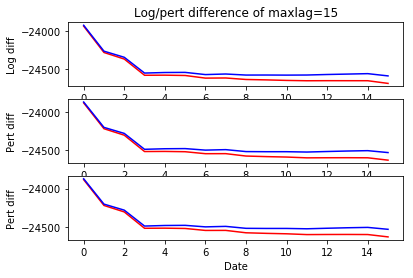

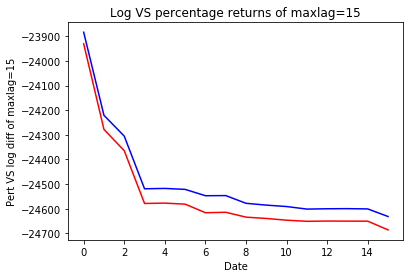

In [12]:
show_plot()

Figure 2 AIC and BIC values comparasion (top), AIC values of log return and percentage return comparison (bottom) of AR(p) model with p from 0 to 15

## Discussion of Q1

1. The comparasion of log returns and percentage returns of the differences between two tickers in Figure 1 shows that the analysts can use either log daily return or percentage daily return for long-term period analysis. 
2. The AIC (red line) and BIC (blue line) criteria are consistent of this analysis.
3. AIC or BIC drops dramatically when maxlag<=4 and approach a slope after maxlap>4. In the meantime, the running time of analysis with maxlag=12 increases sharply from 20.87s to 95.43s with maxlag=15.
4. Table 1, Table2, and Figure 2 consistently shows the best parameter p of AR(p) is 11 (percentage returns, no matter AIC or BIC criterion), or 11 (log returns with AIC criterion) or 10 (log returns with BIC criterion) with the consideration of computation cost.
5. Since the difference of AIC/BIC value between AR(10) and AR(11) are very small, **we conclude that the best fit of this AR model is AR(11).**